# Caption Extraction

## Imports

In [1]:
from gradio_client import Client
import PIL
from PIL import Image as ImPIL
import requests
from matplotlib import pyplot as plt
from IPython.display import display
from IPython.display import Image as ImPy

## Demo Image Selection

In [2]:
import requests

# details of the repo we're going into
host = 'IronIron2121'  
repo = 'visualist-demo-images'
path = 'images'  
branch = 'main'

# build the repo api url, then get its contents
url = f"https://api.github.com/repos/{host}/{repo}/contents/{path}?ref={branch}"
response = requests.get(url)
content = response.json()

# create empty dictionary for name / raw-url pairs
demo_imgs = {}

# append urls and filenames, excluding extensions (.jpg, .png) to dictionary
for index, file in enumerate(content):
    img_name = file['name'][:5]
    raw_url = file['download_url']
    demo_imgs[img_name] = raw_url

print("YOU CAN CHOOSE FROM THE FOLLOWING IMAGES")
for name, url in demo_imgs.items():
    print(f"NAME = {name}")
    display(ImPy(url=url, width=400))
    print("\n\n")

YOU CAN CHOOSE FROM THE FOLLOWING IMAGES
NAME = arno1





NAME = arno3





NAME = cara1





NAME = cara2





NAME = cara3





NAME = cara4





NAME = cara5





NAME = cara6





NAME = cara7





NAME = cara8





NAME = gas_1





NAME = joha1





NAME = joha2





NAME = moond





NAME = visu1





NAME = visu2





NAME = visu3





NAME = visu4





NAME = visu5





NAME = visu6





NAME = visu7





NAME = visu8





NAME = visu9





NAME = visuA





NAME = visuB





NAME = visuC





NAME = visuD





NAME = visuE





NAME = visuF


In [3]:
# choose the api that we're accessing
client = Client("https://xinyu1205-recognize-anything.hf.space/")

Loaded as API: https://xinyu1205-recognize-anything.hf.space/ ✔


## INFERENCE

In [4]:
# select one of our demo images
image_name = 'visuA'
demo_url = demo_imgs[image_name]

# run inference over our selected demo image
# NOTE: The string is empty, but you can fill it with context if you want to demo that feature too
result = client.predict(
    demo_url,
    "",
    fn_index=3
)

# grab the tags and the caption
tags=result[0]
caption=result[1]

# we split the tags by the seperator to get a list we can provide to the segmentation model
list_of_tags = tags.split('|') 

In [5]:
# display the tags and caption next to the image we processed
print(f"TAGS: {tags}\nCAPTION: {caption}\nIMAGE:")
display(ImPy(url=demo_url, width = 500))

TAGS: ring | stem | flower | wedding ring | golden | orange
CAPTION: wedding rings on a stem of orange flowers
IMAGE:


# Sticker Extraction (Grounding And Segmentation)

## Imports

In [6]:
# python imports
import os
from math import floor
import sys
import time

sys.path.append(os.getcwd())

# library imports
import cv2
from matplotlib import pyplot as plt
import numpy as np
from random import randint
import supervision as sv
import torch
import torchvision

# local imports
from groundingdino.util.inference import Model
from models.MobileSAM.setup_model import setup_model
from segment_anything import SamPredictor
from utilities.logging import notif

/home/gokaf001/work/visualist/visualist-ml-projects/notebooks/mask_stickers_from_cloud_tags/mcenv/lib/python3.9/site-packages/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


## Function Definitions

### Segmenting Function

In [7]:
# define function that runs segmentation inference
def segment(seg_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    # set image attribute for our provided segmentation model
    seg_predictor.set_image(image)
    # create empty list to contain our masks
    result_masks = []
    # for every box found by visual grounding mode, find masks and confidence scores
    for box in xyxy:
        # get masks, scores and logits from mask prediction over this box
        masks, scores, logits = seg_predictor.predict(
            box=box,
            multimask_output=True
        )
        # get the mask which has the most confidence for this box
        index = np.argmax(scores)
        # append the most confident mask for this box to our masks array
        result_masks.append(masks[index])
    return np.array(result_masks)

### Mask Bounding Box Finding Functions

I'm sure there's a faster way of doing this, but this will do for now

In [8]:
# find the highest filled point in the mask by checking for alpha along the columns, and iterating down the rows
def find_upmost(mask,height,width):
    for y in range(height):
        for x in range(width):
            if not mask[y][x][-1]:
                pass
            else:
                return y

# find the leftmost filled point in the mask by checking down the the columns, iterating right along the rows  
def find_leftmost(mask,height,width):
    for x in range(width):
        for y in range(height):
            if mask[y][x][-1]:
                return x

# self-explanatory
def find_downmost(mask,height,width):
    for y in range(height-1, -1, -1):
        for x in range(width-1, -1, -1):
            if mask[y][x][-1]:
                return y

# self-explanatory
def find_rightmost(mask,height,width):
    for x in range(width-1, -1, -1):
        for y in range(height-1, -1, -1):
            if mask[y][x][-1]:
                return x

# run all of the above functions on a given mask and return the values
def find_boxpoints(mask):
    height, width, _rgba_ = mask.shape
    upmost = find_upmost(mask,height,width) 
    leftmost = find_leftmost(mask,height,width) 
    downmost = find_downmost(mask,height,width) 
    rightmost = find_rightmost(mask,height,width) 
    return upmost, leftmost, downmost, rightmost

## Path Initialisation

In [9]:
# assign CUDA if GPU is available, else use the CPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



output_ext = 'png' # file type extension for output
image_name = image_name # name of image you want to use

# filenames for output images
rel_anno_path = f"{image_name}" + "_anno" + f".{output_ext}"
rel_mask_path = f"{image_name}" + "_mask" + f".{output_ext}"

# path for image outputs
anno_path = os.path.join(output_dir, rel_anno_path)
mask_path = os.path.join(output_dir, rel_mask_path)



#------------------------------------------------------------------------------------------------------------#

/home/gokaf001/work/visualist/visualist-ml-projects/notebooks/mask_stickers_from_cloud_tags/models/ VALIDATED

#------------------------------------------------------------------------------------------------------------#



#--------------------------------------------------------------------------------------------------------------------------#

/home/gokaf001/work/visualist/visualist-ml-projects/notebooks/mask_stickers_from_cloud_tags/models/GroundingDINO/ VALIDATED

#--------------------------------------------------------------------------------------------------------------------------#



#----------------------------------------------------------------------------------------------------------------------#

/home/gokaf001/work/visualist/visualist-ml-projects/notebooks/mask_stickers_from_cloud_tags/models/MobileSAM/ VALIDATED

#--------------------------------------

## Model Initialisation

In [10]:
notif("BUILDING OBJECT DETECTION MODEL")
# building object detection inference model
det_model = Model(model_config_path=det_config_path,
                  model_checkpoint_path=det_weights_path,
                  device=DEVICE)
 
notif("LOADING PROVIDED IMAGE")
# grab the actual image from the URL so we can manipulate it locally
demo_image = ImPIL.open(requests.get(demo_url, stream=True).raw) # use pil to load from internet
demo_image = np.asarray(demo_image) # convert to numpy array
demo_image = cv2.cvtColor(demo_image, cv2.COLOR_RGB2BGR) # convert to opencv-image

# prompt our models with the tags from the caption generator
CLASSES = list_of_tags

# Presumably these are confidence thresholds for bounding boxes and class prediction
BOX_THRESHOLD = 0.25
TEXT_THRESHOLD = 0.25
NMS_THRESHOLD = 0.8

/home/gokaf001/work/visualist/visualist-ml-projects/notebooks/mask_stickers_from_cloud_tags/mcenv/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]




#------------------------------#

BUILDING OBJECT DETECTION MODEL

#------------------------------#

final text_encoder_type: bert-base-uncased


#----------------------#

LOADING PROVIDED IMAGE

#----------------------#



## Visual Grounding /w Tags

In [11]:
print(CLASSES)

['ring ', ' stem ', ' flower ', ' wedding ring ', ' golden ', ' orange']


In [12]:
# start a timer so we can measure inference time
init_time = floor(time.perf_counter())

notif(f"NOW DETECTING OBJECTS WITH WEIGHTS AT {rel_det_model_dir}")
# detect objects
detections = det_model.predict_with_classes(
    image=demo_image,
    classes=CLASSES,
    box_threshold=BOX_THRESHOLD,
    text_threshold=BOX_THRESHOLD
)

# annotate image with detections
notif("ANNOTATING IMAGE WITH BOUNDING BOX DETECTIONS")
box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections]
annotated_frame = box_annotator.annotate(scene=demo_image.copy(), detections=detections, labels=labels)

# save the annotated grounding dino image
notif(f"SAVING ANNOTATED IMAGE TO {anno_path}")
cv2.imwrite(anno_path, annotated_frame)

# measure how long this inference took
elapsed = floor(time.perf_counter())
anno_time = elapsed - init_time
anno_mins = anno_time // 60
anno_secs = anno_time % 60
notif(f"Annotation Inference completed in {anno_mins} mins and {anno_secs} secs")



#----------------------------------------------------#

NOW DETECTING OBJECTS WITH WEIGHTS AT GroundingDINO/

#----------------------------------------------------#



/home/gokaf001/work/visualist/visualist-ml-projects/notebooks/mask_stickers_from_cloud_tags/mcenv/lib/python3.9/site-packages/transformers/modeling_utils.py:881: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/gokaf001/work/visualist/visualist-ml-projects/notebooks/mask_stickers_from_cloud_tags/mcenv/lib/python3.9/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")




#--------------------------------------------#

ANNOTATING IMAGE WITH BOUNDING BOX DETECTIONS

#--------------------------------------------#



#------------------------------------------------------------------------------------------------------------------------------------------------#

SAVING ANNOTATED IMAGE TO /home/gokaf001/work/visualist/visualist-ml-projects/notebooks/mask_stickers_from_cloud_tags/bin/outputs/visuA_anno.png

#------------------------------------------------------------------------------------------------------------------------------------------------#



#----------------------------------------------------#

Annotation Inference completed in 0 mins and 19 secs

#----------------------------------------------------#



In [13]:
# NMS post process - get rid of overlapping boxes
notif(f"Before NMS: {len(detections.xyxy)} boxes")
nms_idx = torchvision.ops.nms(
    torch.from_numpy(detections.xyxy),
    torch.from_numpy(detections.confidence),
    NMS_THRESHOLD
).numpy().tolist()

# replace detections with NMS approved detections (I think?) 
detections.xyxy = detections.xyxy[nms_idx]
detections.confidence = detections.confidence[nms_idx]
detections.class_id = detections.class_id[nms_idx]
notif(f"After NMS: {len(detections.xyxy)} boxes")



#------------------#

Before NMS: 9 boxes

#------------------#



#------------------#

After NMS: 9 boxes

#------------------#



## Object Segmentation

In [14]:
notif("LOADING OBJECT SEGMENTATION MODEL")
# building segmentation predictor
checkpoint = torch.load(seg_weights_path) # load model from given path
seg_model = setup_model() 
seg_model.load_state_dict(checkpoint, strict=True)
seg_model.to(device=DEVICE)

seg_predictor = SamPredictor(seg_model)
notif("NOW BEGINNING MASK INFERENCE")

# give output of segment function (np.array with masks) as new attribute for detections 
detections.mask = segment(
    seg_predictor=seg_predictor,
    image=cv2.cvtColor(demo_image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections]

# annotate the image with the masks, then annotate it with the bounding boxes
annotated_image = mask_annotator.annotate(scene=demo_image.copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

# save the annotated grounded-sam image
notif(f"SAVING MASKED IMAGE TO {mask_path}")
cv2.imwrite(mask_path, annotated_image)

# get total time elapsed so far
elapsed = floor(time.perf_counter())
# calculate how long the masking inference took
mask_time = elapsed - (init_time + anno_time)
# calculate how long this whole process has taken
end_time = elapsed - init_time

# make masking time more human-readable, then print
mask_mins = mask_time // 60
mask_secs = mask_time % 60
print(f"Mask Inference completed in {mask_mins} mins and {mask_secs} secs\n\n")

# make end time more human-readable, then print
end_mins = end_time // 60
end_secs = end_time % 60
print(f"Overall Inference completed in {end_mins} mins and {end_secs} secs")




#--------------------------------#

LOADING OBJECT SEGMENTATION MODEL

#--------------------------------#

LR SCALES: [0.08589934592000005, 0.10737418240000006, 0.13421772800000006, 0.1677721600000001, 0.20971520000000007, 0.2621440000000001, 0.3276800000000001, 0.4096000000000001, 0.5120000000000001, 0.6400000000000001, 0.8, 1.0]


#----------------------------#

NOW BEGINNING MASK INFERENCE

#----------------------------#



#--------------------------------------------------------------------------------------------------------------------------------------------#

SAVING MASKED IMAGE TO /home/gokaf001/work/visualist/visualist-ml-projects/notebooks/mask_stickers_from_cloud_tags/bin/outputs/visuA_mask.png

#--------------------------------------------------------------------------------------------------------------------------------------------#

Mask Inference completed in 0 mins and 6 secs


Overall Inference completed in 0 mins and 25 secs


In [23]:
','.join(labels)

'ring  0.55, flower  0.37, flower  0.33, stem  0.31, flower  0.30, stem  0.30, flower  0.29, stem  0.28, stem  0.27'

<Figure size 640x480 with 0 Axes>

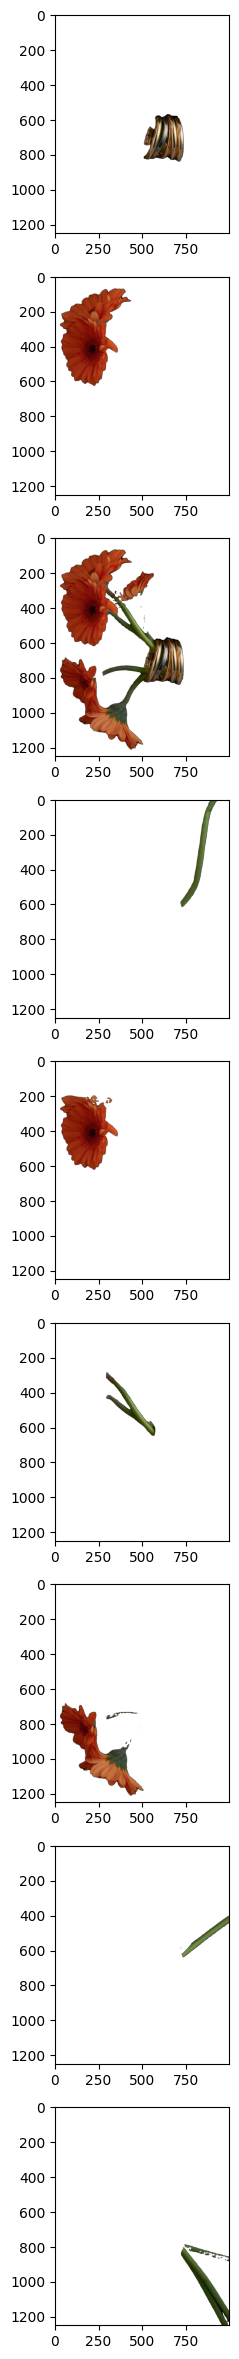

In [15]:
# get original image
original_image = cv2.cvtColor(demo_image, cv2.COLOR_BGR2RGB)

# get the number of retrieved object masks
mask_num = len(detections.mask)

# i know this is a very hacky fix. don't judge me
if mask_num < 2:
    plot_num = 2
else:
    plot_num = mask_num


# initialise pyplot figures
plt.figure()

# initialise subplots so we can display masks sequentially
fig, axes = plt.subplots(plot_num,1,figsize=(10,30))

# set up an empty list to hold the output masks
mask_outs = []

for i in range(mask_num):
    # get mask corresponding to this iteration of loop, convert from boolean(True/False) to integer(1/0) form
    this_mask = detections.mask[i].astype('int8')

    # do a bitwise AND operation to mask out the original image
    masked_image = cv2.bitwise_and(original_image,original_image,mask=this_mask)

    # get a version of the masked output in grayscale
    temp = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    
    # get the alpha values
    _,alpha = cv2.threshold(temp,0,255,cv2.THRESH_BINARY)
    
    # get the rgb values from the mask
    b, g, r = cv2.split(masked_image)
    
    # make a list containing RGB values and Alpha
    bgra = [b,g,r,alpha]

    # merge the RGB values and alpha values to create image transparent outside of mask
    masked_trim = cv2.merge(bgra,4)
    mask_outs.append(masked_trim)
    axes[i].imshow(masked_trim)

In [16]:
# make a list of dictionaries containing the coordinates for a bounding box around every mask
box_crops = [{'box_top': (upmost,leftmost),'box_bot' : (downmost,rightmost)}\
              for upmost, leftmost, downmost, rightmost in (find_boxpoints(mask) for mask in mask_outs)]

# empty list for final mask crops
final_masks = []

for index, box in enumerate(box_crops):
    # top left point of box
    Y_1 = box['box_top'][0]
    X_1 = box['box_top'][1]

    # bottom right point of box
    Y_2 = box['box_bot'][0]
    X_2 = box['box_bot'][1]

    # crop the image from the overall scene with slicing, then flip colour encoding for output
    cropped_mask = mask_outs[index][Y_1:Y_2, X_1:X_2]
    cropped_mask = cv2.cvtColor(cropped_mask, cv2.COLOR_BGR2RGB)
    
    # add to the list of final stickers, give random output name, and write to disk
    final_masks.append(cropped_mask)
    output_name = f'mask{randint(0,9999)}.png'
    cv2.imwrite(os.path.join(output_dir, output_name), cropped_mask)

## Final Stickers

<Figure size 640x480 with 0 Axes>

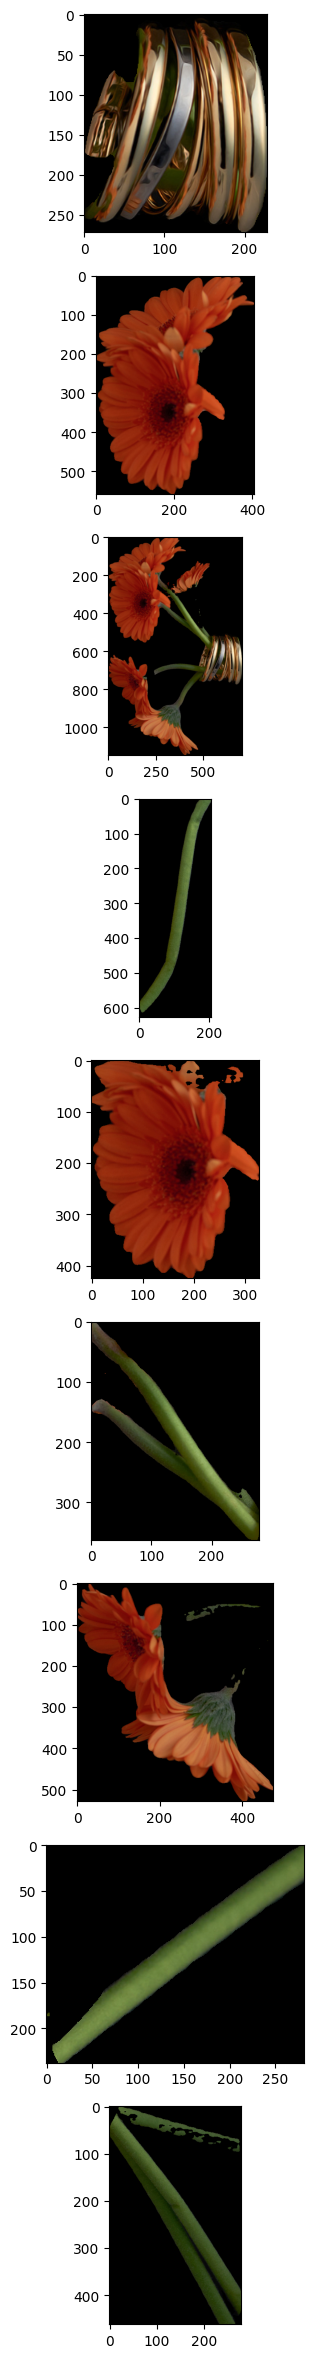

In [17]:
# get number of cropped out masks
num_cropped = len(final_masks)

# initialise pyplot figures
plt.figure()

# initialise subplots so we can display masks sequentially
fig, axes = plt.subplots(num_cropped,1,figsize=(10,30))

for i in range(num_cropped):
    axes[i].imshow(final_masks[i][:,:,::-1])